# School TOD Categories

Model 1: Estimates arrival time at schools.<br>
Model 2: Estimates departure time from schools. 

Note: Contrary to Home-work-home trips, model 2 estimates departure time from school rather than dwell time at school. 

TO DO: 
 - Improve model specification (CHECK)
 - Check urbansim_templates.models.SmallMultinomialStep() functionality. It seems is not working properly. (ASK MAX)
 - Validation process (test vs train data)

In [1]:
from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings; warnings.simplefilter('ignore')

import pandas as pd
# import pandana as pdna
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

import scipy.stats as st
from scipy.stats import skewnorm
import pylogit as pl
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
import seaborn as sns

import pickle
import dill

# import matplotlib
# matplotlib.style.use('ggplot')

%matplotlib inline

pd.options.display.max_columns = 80

## Loading data 

In [2]:
trips = pd.read_csv('/home/emma/ual_model_workspace/spring-2019-models/notebooks-emma/HStrips_031219.csv', index_col = 0)

# Creating TOD categories for school arrival time and school departure time

In [3]:
#select people who make both home-school and school-home trips:
tripsII = trips.groupby('HHPER').filter(lambda x: len(x) == 2)

In [4]:
#make sure all home-school trip rows are listed first
tripsIII = tripsII.sort_values(['HHPER','origin'])

#move school-home trip info up into home-school trip rows
tripsIII['school_dwell'] = tripsIII.groupby('HHPER', group_keys=False).origin_dwell.shift(-1)
tripsIII['school_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ST.shift(-1)
tripsIII['SH_trip_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ET.shift(-1)
tripsIII['SH_trip_ET'] = tripsIII.groupby('HHPER', group_keys=False).trip_ET.shift(-1)
tripsIII['SH_TT'] = tripsIII.groupby('HHPER', group_keys=False).TT.shift(-1)
tripsIII['SH_mode'] = tripsIII.groupby('HHPER', group_keys=False).MODE.shift(-1)

In [5]:
tripsIII = tripsIII.groupby('HHPER').first().reset_index()

In [6]:
tripsIII.rename(columns = {'origin_dwell':'home_dwell','origin_ST':'home_ST','origin_ET':'HS_trip_ST',
                           'trip_ET':'HS_trip_ET','TT':'HS_TT','MODE':'HS_mode','TOD':'HS_TOD'},inplace = True)

In [7]:
#School arrival time TOD category
tripsIII['School_arrival_TOD'] = pd.cut(tripsIII.HS_trip_ET, 
                             np.array([0, 3.0, 7.75, 8.5, 9.5, 15.0, 24.0]), 
                             labels = [6,1,2,3,4,5]).replace(6,5).astype(int)

#School departure time TOD category
tripsIII['School_departure_TOD'] = pd.cut(tripsIII.SH_trip_ST, 
                             np.array([0, 10, 12, 15, 17, 20, 24]), 
                             labels = [6,1,2,3,4,5]).replace(6, 5).astype(int)

## Add the demographic variables

In [8]:
person = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_PER.csv')
person[person.SAMPN == 1032053]

,SAMPN,PERNO,RELAT,GEND,AGE,AGEB,HISP,RACE1,RACE2,RACE3,RACE4,O_RACE,NTVTY,CNTRY,LIC,USER,TRANS,TPTYP1,TPTYP2,TPTYP3,TPTYP4,TPTYP5,TPTYP6,TPTYP7,O_TPTYP,CLIP1,CLIP2,CLIP3,COMP,MET,PASSTL,FLEX,EMPLY,WKSTAT,O_WKSTAT,JOBS,WLOC,WNAME,WCITY,WSTAT,...,HVLOG,PTRIPS,TOLLF,TOLLR1,TOLLR2,TOLLR3,TOLLR4,TOLLR5,TOLLR6,TOLLR7,TOLLR8,TOLLR9,TOLLR10,TOLLB1,TOLLB2,TOLLB3,TOLLB4,TOLLB5,TOLLB6,TOLLB7,TOLLB8,TOLLB9,TOLLB10,HOVL,NOGOWHY,NOGOWHY_O,InComplete,Moto_trip,WCTFIP,WTRACT,SCTFIP,STRACT,WPrimaryCity,WSTFIP,W2PrimaryCity,W2STFIP,SPrimaryCity,SSTFIP,PERWGT,EXPPERWGT
7,1032053,1,1,2,30,NaN,1,1.0,NaN,NaN,NaN,NaN,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,NaN,NaN,1.0,1.0,HIDDEN,MODESTO,CA,...,1.0,15.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,99.0,504.0,NaN,NaN,MODESTO,6.0,NaN,NaN,NaN,NaN,0.134135,45.447024
8,1032053,2,2,1,31,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,2,9998.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.094628,32.061393
9,1032053,3,3,2,9,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,47.0,1602.0,NaN,NaN,NaN,NaN,MERCED,6.0,0.059297,20.090794
10,1032053,4,3,2,7,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,47.0,1602.0,NaN,NaN,NaN,NaN,MERCED,6.0,0.059297,20.090794
11,1032053,5,3,2,5,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,47.0,1602.0,NaN,NaN,NaN,NaN,MERCED,6.0,0.059297,20.090794
12,1032053,6,3,1,1,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059297,20.090794


In [9]:
person.loc[:,['SXCORD', 'SYCORD']]
person.SXCORD.replace('HIDDEN', np.nan, inplace = True)

In [10]:
person.SXCORD.notnull().sum()

2601

In [11]:
person.SNAME.replace('HIDDEN', np.nan, inplace = True)

In [12]:
person = person[['SAMPN','PERNO','GEND','AGE','HISP','RACE1','RACE2','RACE3','RACE4',
                 'EDUCA']]

In [13]:
person['HHPER'] = person['SAMPN'].map(str) + person['PERNO'].map(str)

In [14]:
hh_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_HH.csv')[
  ['SAMPN','HHVEH','OWN','INCOM','HHSIZ']]

In [15]:
demo = person.merge(hh_df,on = 'SAMPN',how = 'left')

demo.HHPER.nunique()

109113

In [16]:
demo.head()

,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,EDUCA,HHPER,HHVEH,OWN,INCOM,HHSIZ
0,1031985,1,1,74,2,1.0,NaN,NaN,NaN,6,10319851,2,1,3,2
1,1031985,2,2,73,2,1.0,NaN,NaN,NaN,6,10319852,2,1,3,2
2,1032036,1,1,46,2,1.0,NaN,NaN,NaN,6,10320361,1,1,7,5
3,1032036,2,2,47,2,1.0,97.0,NaN,NaN,6,10320362,1,1,7,5
4,1032036,3,1,15,2,1.0,97.0,NaN,NaN,1,10320363,1,1,7,5


In [17]:
na_dict = {
    'GEND':[9],
    'AGE':[998,999],
    'EDUCA':[8,9],
    'HHVEH':[98,99],
    'OWN':[7,8,9],
    'INCOM':[98,99],
    'HHSIZ':[98,99]
}

for col in na_dict:
    for vals in na_dict[col]:
        demo[col] = demo[col].replace(vals,np.nan)

In [18]:
demo.isnull().sum()

SAMPN         0
PERNO         0
GEND        311
AGE        3924
HISP          0
RACE1         5
RACE2    104862
RACE3    108879
RACE4    109090
EDUCA      2088
HHPER         0
HHVEH         0
OWN         339
INCOM      8839
HHSIZ         0
dtype: int64

In [19]:
demo = demo.dropna(subset = ['GEND', 'AGE', 'EDUCA','HHVEH','OWN','INCOM','HHSIZ'])

In [20]:
demo.shape

(95912, 15)

In [21]:
tripsIII['HHPER'] = tripsIII['HHPER'].map(str)

trips1 = pd.merge(tripsIII, demo, on='HHPER')

print (len(tripsIII.index))
print (len(trips1.index))

9857
8997


In [22]:
#Selecting K-12 trips that are more likeley to be K-12 studnets. 
trips_final = trips1[(trips1.AGE <= 18) & (trips1.EDUCA <= 2)]

In [23]:
trips_final.columns

Index(['HHPER', 'HHPERTRIP', 'origin', 'home_dwell', 'home_ST', 'HS_trip_ST',
       'HS_trip_ET', 'HS_TT', 'HS_mode', 'school_dwell', 'school_ST',
       'SH_trip_ST', 'SH_trip_ET', 'SH_TT', 'SH_mode', 'School_arrival_TOD',
       'School_departure_TOD', 'SAMPN', 'PERNO', 'GEND', 'AGE', 'HISP',
       'RACE1', 'RACE2', 'RACE3', 'RACE4', 'EDUCA', 'HHVEH', 'OWN', 'INCOM',
       'HHSIZ'],
      dtype='object')

## Prepate data for estimation 

In [24]:
# trips_final.isnull().sum()

In [25]:
trips_final['minority'] = np.where((trips_final['HISP'].isin([1.0]) |
                                trips_final['RACE1'].isin([2.0]) | trips_final['RACE2'].isin([2.0]) | trips_final['RACE3'].isin([2.0]) | trips_final['RACE4'].isin([2.0]) |
                              trips_final['RACE1'].isin([3.0]) | trips_final['RACE2'].isin([3.0]) | trips_final['RACE3'].isin([3.0]) | trips_final['RACE4'].isin([3.0]) |
                              trips_final['RACE1'].isin([4.0]) | trips_final['RACE2'].isin([4.0]) | trips_final['RACE3'].isin([4.0]) | trips_final['RACE4'].isin([4.0]) |
                              trips_final['RACE1'].isin([5.0]) | trips_final['RACE2'].isin([5.0]) | trips_final['RACE3'].isin([5.0]) | trips_final['RACE4'].isin([5.0]) |
                              trips_final['RACE1'].isin([97.0]) | trips_final['RACE2'].isin([97.0]) | trips_final['RACE3'].isin([97.0]) | trips_final['RACE4'].isin([97.0])),1,0)

# trips_final['black'] = np.where((trips1['RACE1'].isin([2.0]) | trips1['RACE2'].isin([2.0]) | trips1['RACE3'].isin([2.0]) | trips1['RACE4'].isin([2.0])),1,0)
# trips_final['native'] = np.where((trips1['RACE1'].isin([3.0]) | trips1['RACE2'].isin([3.0]) | trips1['RACE3'].isin([3.0]) | trips1['RACE4'].isin([3.0])),1,0)
# trips_final['asian'] = np.where((trips1['RACE1'].isin([4.0]) | trips1['RACE2'].isin([4.0]) | trips1['RACE3'].isin([4.0]) | trips1['RACE4'].isin([4.0])),1,0)

In [26]:
#Race variables
trips_final['black']  = np.where((trips_final['RACE1'].isin([2.0]) | trips_final['RACE2'].isin([2.0]) | trips_final['RACE3'].isin([2.0]) | trips_final['RACE4'].isin([2.0])),1,0)
trips_final['native'] = np.where((trips_final['RACE1'].isin([3.0]) | trips_final['RACE2'].isin([3.0]) | trips_final['RACE3'].isin([3.0]) | trips_final['RACE4'].isin([3.0])),1,0)
trips_final['asian']  = np.where((trips_final['RACE1'].isin([4.0]) | trips_final['RACE2'].isin([4.0]) | trips_final['RACE3'].isin([4.0]) | trips_final['RACE4'].isin([4.0])),1,0)

In [27]:
#Income Varibles 
trips_final['hh_inc_under_25k'] = (trips_final.INCOM.between(0,2, inclusive = True )).astype(int)
trips_final['hh_inc_25_to_75k'] = (trips_final.INCOM.between(3,5, inclusive = True )).astype(int)
trips_final['hh_inc_75_to_200k'] = (trips_final.INCOM.between(6,8, inclusive = True )).astype(int)
trips_final['hh_inc_over_200k'] = (trips_final.INCOM.between(9,10, inclusive = True )).astype(int)

In [28]:
#Age variables 
trips_final['age_0_5'] = (trips_final.AGE.between(0,4, inclusive = True )).astype(int)
trips_final['age_5_12'] = (trips_final.AGE.between(5,11, inclusive = True )).astype(int)
trips_final['age_12_15'] = (trips_final.AGE.between(12,14, inclusive = True )).astype(int)
trips_final['age_15_18'] = (trips_final.AGE.between(15,18, inclusive = True )).astype(int)

In [29]:
#Education variables
trips_final['lessGED'] = np.where(trips_final['EDUCA'].isin([1.0]),1,0)
trips_final['GEDsomeBach'] = np.where(trips_final['EDUCA'].isin([2.0,3.0]),1,0)

In [30]:
#Gender variable. 1 Famale, 0 Male. 
trips_final['female'] = trips_final['GEND'] - 1 

In [31]:
#Homw ownership
trips_final['own_home'] = (trips_final.OWN == 1).astype(int)
trips_final['rent_home'] = (trips_final.OWN == 2).astype(int)

In [32]:
#No veh in the household
trips_final['noveh'] = (trips_final.HHVEH == 0).astype(int)

In [33]:
#HH size 
trips_final['hh_size_over_4'] = np.where(trips_final.HHSIZ.between(4,8,inclusive = True),1,0)

In [34]:
trips_final['person_id'] = trips_final['HHPER']

In [35]:
# #Not suitable for simulation 
# #Education variables
# trips_final['lessGED'] = np.where(trips_final['EDUCA'].isin([1.0]),1,0)
# trips_final['GEDsomeBach'] = np.where(trips_final['EDUCA'].isin([2.0,3.0]),1,0)


# #Gender variable
# trips_final['female'] = trips_final['GEND'] - 1

# #Vehicle ownership variables 
# trips_final['tenure_2'] = trips_final['OWN'] - 1
# trips_final['noveh'] = np.where(trips_final.HHVEH.isin([0.0]),1,0)

# #HH size 
# trips_final['hh_size_4plusper'] = np.where(trips_final.HHSIZ.between(4,8,inclusive = True),1,0)


# #Time of the day dummies. 
# trips_final['TOD_3to745'] = np.where(trips_final['School_arrival_TOD'].isin([0]),1,0)
# trips_final['TOD_830to930'] = np.where(trips_final['School_arrival_TOD'].isin([2]),1,0)
# trips_final['TOD_930to1500'] = np.where(trips_final['School_arrival_TOD'].isin([3]),1,0)
# trips_final['TOD_1500up'] = np.where(trips_final['School_arrival_TOD'].isin([4]),1,0)

## Estimation 

### School arrival time 

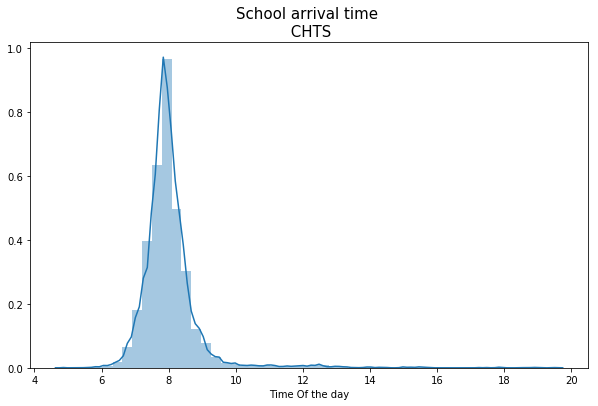

In [36]:
#Plotting distribution for reference 
# plt.hist(trips_final.HS_trip_ET, bins= list(range(0,24,1)))
plt.figure(figsize=(10, 6))
sns.distplot(trips_final.HS_trip_ET)
plt.xlabel('Time Of the day')
plt.title('School arrival time \n CHTS', fontsize=15);


According to the graph, most observations should be in TOD category 1, 2 and 3. 

In [40]:
X_train, X_test = train_test_split(trips_final, test_size=0.3, random_state=42)

In [69]:
[-1:]

[7799]

In [70]:
trips_final.shape

(7799, 61)

In [74]:
def from_wide_to_long(data_wide):
    
    #Creating a fake alternative specific varible and its corresponding availability variable. 
    for x in [1,2,3,4,5]:
        name = 'tt_'+str(x)
        av_name = 'av_'+str(x)
        data_wide[name] = [random.randint(1,20) for x in range(len(data_wide))]
        data_wide[av_name] = 1

    #Preparing for transformation
    ind_variables = ['minority', 'black','native', 'asian', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
                     'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5', 'age_5_12','age_12_15', 
                     'age_15_18',  'female','own_home', 'rent_home', 'noveh', 'hh_size_over_4']

    alt_varying_variables = {u'travel_time': dict([(1, 'tt_1'),
                                                   (2, 'tt_2'),
                                                   (3, 'tt_3'),
                                                   (4, 'tt_4'),
                                                   (5, 'tt_5')])}

    availability_variables = dict(zip(range(1, 6), ['av_1','av_2','av_3','av_4','av_5']))
    
    data_wide['obs_id'] = list(range(1, len(data_wide) + 1))

    # Perform the desired conversion
    data_long = pl.convert_wide_to_long(wide_data=data_wide,
                                           ind_vars = ind_variables,
                                           alt_specific_vars = alt_varying_variables,
                                           availability_vars = availability_variables, 
                                           obs_id_col = 'obs_id',
                                           choice_col= 'School_arrival_TOD')
    
    
    return data_long

In [51]:
#Converting wide to long format 
#I need to trick pylogits function with alternative specific variable - Note that we don't truly have them for this case. 
#Creating a fake alternative specific varible and its corresponding availability variable. 
for x in [1,2,3,4,5]:
    name = 'tt_'+str(x)
    av_name = 'av_'+str(x)
    trips_final[name] = [random.randint(1,20) for x in range(len(trips_final))]
    trips_final[av_name] = 1
    
#Preparing for transformation
ind_variables = ['minority', 'black','native', 'asian', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
                 'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5', 'age_5_12','age_12_15', 
                 'age_15_18',  'female','own_home', 'rent_home', 'noveh', 'hh_size_over_4']

alt_varying_variables = {u'travel_time': dict([(1, 'tt_1'),
                                               (2, 'tt_2'),
                                               (3, 'tt_3'),
                                               (4, 'tt_4'),
                                               (5, 'tt_5')])}

availability_variables = dict(zip(range(1, 6), ['av_1','av_2','av_3','av_4','av_5']))

# Perform the desired conversion
trips_long = pl.convert_wide_to_long(wide_data= trips_final,
                                       ind_vars = ind_variables,
                                       alt_specific_vars = alt_varying_variables,
                                       availability_vars = availability_variables, 
                                       obs_id_col = 'person_id',
                                       choice_col= 'School_arrival_TOD')

In [59]:
TOD_specification = OrderedDict()
TOD_names = OrderedDict()

TOD_specification["intercept"] = [2, 3, 4, 5]
TOD_names["intercept"] = ['TOD_2', 'TOD_3', 'TOD_4', 'TOD_5' ]

TOD_specification["age_5_12"] = [2, 3, 4,]
TOD_names["age_5_12"] = ['age_5_12_2', 'age_5_12_3', 'age_5_12_4' ]

TOD_specification["age_12_15"] = [2, 3, 4, 5]
TOD_names["age_12_15"] = ['age_12_15_2', 'age_12_15_3', 'age_12_15_4', 'age_12_15_5' ]

TOD_specification["age_15_18"] = [2, 3, 4]
TOD_names["age_15_18"] = ['age_15_18_2', 'age_15_18_3', 
                          'age_15_18_4' ]

TOD_specification['minority'] = [2, 3]
TOD_names['minority'] = ['minority_2', 'minority_3']

TOD_specification['asian'] = [2, 3, 4]
TOD_names['asian'] = ['asian_2', 'asian_3', 'asian_4']

TOD_specification['hh_inc_under_25k'] = [2, 3]
TOD_names['hh_inc_under_25k'] = ['hh_inc_under_25k_2', 'hh_inc_under_25k_3']

TOD_specification['hh_inc_25_to_75k'] = [2, 3]
TOD_names['hh_inc_25_to_75k'] = ['hh_inc_25_to_75k_2', 'hh_inc_25_to_75k_3']

TOD_specification['hh_inc_75_to_200k'] = [2, 3]
TOD_names['hh_inc_75_to_200k'] = ['hh_inc_75_to_200k_2', 'hh_inc_75_to_200k_3']

TOD_specification['female'] = [2, 3, 4]
TOD_names['female'] = ['female_2', 'female_3', 'female_4']

TOD_specification['hh_size_over_4'] = [ 4]
TOD_names['hh_size_over_4'] = ['hh_size_over_4_4']



In [43]:
S_TOD_Categories = pl.create_choice_model(data=trips_long,
                                     alt_id_col='alt_id',
                                     obs_id_col='person_id',
                                     choice_col='School_arrival_TOD',
                                     specification=TOD_specification,
                                     model_type="MNL",
                                     names=TOD_names)

S_TOD_Categories.fit_mle(np.zeros(29))
S_TOD_Categories.get_statsmodels_summary()

Log-likelihood at zero: -12,552.0063
Initial Log-likelihood: -12,552.0063
Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -7,872.5874


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:          School_arrival_TOD   No. Observations:                7,799
Model:             Multinomial Logit Model   Df Residuals:                    7,770
Method:                                MLE   Df Model:                           29
Date:                     Tue, 27 Aug 2019   Pseudo R-squ.:                   0.373
Time:                             15:20:20   Pseudo R-bar-squ.:               0.370
AIC:                            15,803.175   Log-Likelihood:             -7,872.587
BIC:                            16,005.066   LL-Null:                   -12,552.006
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
TOD_2                   0.9942      0.144      6.914      0.000       0.712       1.276
TOD_3                   0.8762      0.175      5.019      0.000       0.534       1.218
TOD_4                  -0.3815      0.206     -1.852      0.064      -0.785       0.022
TOD_5                  -4.7316      0.230    -20.534      0.000      -5.183      -4.280
age_5_12_2              0.3923      0.121      3.245      0.001       0.155       0.629
age_5_12_3             -1.1511      0.137     -8.401      0.000      -1.420      -0.883
age_5_12_4             -1.8942      0.199     -9.538      0.000      -2.283      -1.505
age_12_15_2            -0.3365      0.125     -2.686      0.007      -0.582      -0.091
age_12_15_3            -1.8077      0.152    -11.857      0.000      -2.107      -1.509
age_12_15_4            -2.9105      0.274    -10.605      0.000      -3.448      -2.373
age_12_15_5            -1.8925      1.027     -1.843      0.065      -3.905       0.120
age_15_18_2            -0.7753      0.124     -6.244      0.000      -1.019      -0.532
age_15_18_3            -2.2610      0.154    -14.707      0.000      -2.562      -1.960
age_15_18_4            -1.8316      0.192     -9.547      0.000      -2.208      -1.456
minority_2             -0.1271      0.059     -2.139      0.032      -0.244      -0.011
minority_3             -0.2529      0.102     -2.482      0.013      -0.453      -0.053
asian_2                 0.2402      0.094      2.559      0.010       0.056       0.424
asian_3                 0.6079      0.142      4.276      0.000       0.329       0.887
asian_4                 0.4827      0.200      2.413      0.016       0.091       0.875
hh_inc_under_25k_2     -0.6504      0.114     -5.694      0.000      -0.874      -0.427
hh_inc_under_25k_3     -0.9118      0.183     -4.990      0.000      -1.270      -0.554
hh_inc_25_to_75k_2     -0.6105      0.101     -6.020      0.000      -0.809      -0.412
hh_inc_25_to_75k_3     -0.8210      0.153     -5.379      0.000      -1.120      -0.522
hh_inc_75_to_200k_2    -0.4127      0.096     -4.310      0.000      -0.600      -0.225
hh_inc_75_to_200k_3    -0.4910      0.138     -3.555      0.000      -0.762      -0.220
female_2               -0.1267      0.051     -2.506      0.012      -0.226      -0.028
female_3               -0.1548      0.084     -1.846      0.065      -0.319       0.010
female_4               -0.2891      0.138     -2.098      0.036      -0.559      -0.019
hh_size_over_4_4       -0.3172      0.156     -2.027      0.043      -0.624      -0.010
=======================================================================================
"""

In [72]:
X_train, X_test = train_test_split(trips_final, test_size=0.3, random_state=42)

In [78]:
X_train_long = from_wide_to_long(X_train)
S_TOD_Categories = pl.create_choice_model(data=X_train_long,
                                     alt_id_col='alt_id',
                                     obs_id_col='obs_id',
                                     choice_col='School_arrival_TOD',
                                     specification=TOD_specification,
                                     model_type="MNL",
                                     names=TOD_names)

S_TOD_Categories.fit_mle(np.zeros(29))
S_TOD_Categories.get_statsmodels_summary()

Log-likelihood at zero: -8,785.9216
Initial Log-likelihood: -8,785.9216
Estimation Time for Point Estimation: 0.29 seconds.
Final log-likelihood: -5,485.3935


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:          School_arrival_TOD   No. Observations:                5,459
Model:             Multinomial Logit Model   Df Residuals:                    5,430
Method:                                MLE   Df Model:                           29
Date:                     Wed, 25 Sep 2019   Pseudo R-squ.:                   0.376
Time:                             16:02:31   Pseudo R-bar-squ.:               0.372
AIC:                            11,028.787   Log-Likelihood:             -5,485.393
BIC:                            11,220.333   LL-Null:                    -8,785.922
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
TOD_2                   1.0446      0.172      6.057      0.000       0.707       1.383
TOD_3                   1.0110      0.206      4.899      0.000       0.606       1.416
TOD_4                  -0.5230      0.255     -2.049      0.040      -1.023      -0.023
TOD_5                  -4.8617      0.290    -16.777      0.000      -5.430      -4.294
age_5_12_2              0.3948      0.144      2.736      0.006       0.112       0.678
age_5_12_3             -1.2225      0.162     -7.546      0.000      -1.540      -0.905
age_5_12_4             -1.7461      0.241     -7.254      0.000      -2.218      -1.274
age_12_15_2            -0.2897      0.150     -1.937      0.053      -0.583       0.003
age_12_15_3            -1.7618      0.178     -9.879      0.000      -2.111      -1.412
age_12_15_4            -2.7087      0.324     -8.350      0.000      -3.345      -2.073
age_12_15_5            -1.3863      1.042     -1.330      0.183      -3.429       0.656
age_15_18_2            -0.8293      0.148     -5.598      0.000      -1.120      -0.539
age_15_18_3            -2.3653      0.182    -12.991      0.000      -2.722      -2.008
age_15_18_4            -1.9146      0.240     -7.976      0.000      -2.385      -1.444
minority_2             -0.1268      0.071     -1.790      0.073      -0.266       0.012
minority_3             -0.3028      0.120     -2.513      0.012      -0.539      -0.067
asian_2                 0.2932      0.112      2.624      0.009       0.074       0.512
asian_3                 0.6938      0.168      4.142      0.000       0.365       1.022
asian_4                 0.6775      0.232      2.917      0.004       0.222       1.133
hh_inc_under_25k_2     -0.7269      0.138     -5.280      0.000      -0.997      -0.457
hh_inc_under_25k_3     -1.0718      0.221     -4.841      0.000      -1.506      -0.638
hh_inc_25_to_75k_2     -0.6523      0.122     -5.330      0.000      -0.892      -0.412
hh_inc_25_to_75k_3     -0.8331      0.180     -4.621      0.000      -1.186      -0.480
hh_inc_75_to_200k_2    -0.4987      0.116     -4.304      0.000      -0.726      -0.272
hh_inc_75_to_200k_3    -0.5814      0.164     -3.536      0.000      -0.904      -0.259
female_2               -0.1524      0.060     -2.519      0.012      -0.271      -0.034
female_3               -0.1633      0.100     -1.638      0.101      -0.359       0.032
female_4               -0.4470      0.171     -2.619      0.009      -0.781      -0.112
hh_size_over_4_4       -0.2321      0.196     -1.183      0.237      -0.617       0.153
=======================================================================================
"""

In [79]:
X_test_long = from_wide_to_long(X_test)

probabilities = S_TOD_Categories.predict(X_test_long)

array([0.36016969, 0.5555343 , 0.06262476, ..., 0.15866874, 0.01611825,
       0.00120791])

In [81]:
X_test_long['probabilities'] = S_TOD_Categories.predict(X_test_long)

In [86]:
X_test_long.head()

,obs_id,alt_id,School_arrival_TOD,minority,black,native,asian,hh_inc_under_25k,hh_inc_25_to_75k,hh_inc_75_to_200k,hh_inc_over_200k,age_0_5,age_5_12,age_12_15,age_15_18,female,own_home,rent_home,noveh,hh_size_over_4,travel_time,intercept,probabilities
0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1.0,0,1,0,1,6,1.0,0.360170
1,1,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1.0,0,1,0,1,10,1.0,0.555534
2,1,3,0,1,0,0,0,1,0,0,0,0,1,0,0,1.0,0,1,0,1,18,1.0,0.062625
3,1,4,0,1,0,0,0,1,0,0,0,0,1,0,0,1.0,0,1,0,1,4,1.0,0.018885
4,1,5,0,1,0,0,0,1,0,0,0,0,1,0,0,1.0,0,1,0,1,4,1.0,0.002787


In [90]:
resutls = X_test_long.sort_values('probabilities', ascending = False).groupby('obs_id').agg({'probabilities': 'first', 'alt_id':'first'})

In [92]:
resutls.alt_id.value_counts()

2    1558
1     759
3      23
Name: alt_id, dtype: int64

In [95]:
X_test.School_arrival_TOD.value_counts()

2    1192
1     841
3     219
4      81
5       7
Name: School_arrival_TOD, dtype: int64

In [126]:
X_test.shape

(2340, 27)

In [127]:
pd.crosstab( X_test.School_arrival_TOD, resutls.alt_id)

AttributeError: 'DataFrame' object has no attribute 'School_arrival_TOD'

In [77]:
trips_final.columns
variables = ['School_arrival_TOD','GEND', 'AGE', 'HISP',
       'EDUCA', 'HHVEH', 'OWN', 'INCOM',
       'HHSIZ', 'minority', 'black', 'native', 'asian', 'hh_inc_under_25k',
       'hh_inc_25_to_75k', 'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5',
       'age_5_12', 'age_12_15', 'age_15_18', 'lessGED', 'GEDsomeBach',
       'female', 'own_home', 'rent_home', 'noveh', 'hh_size_over_4']

gradient_boosting_data = trips_final[variables]

X = gradient_boosting_data.drop(columns =['School_arrival_TOD'])
y = gradient_boosting_data.School_arrival_TOD
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

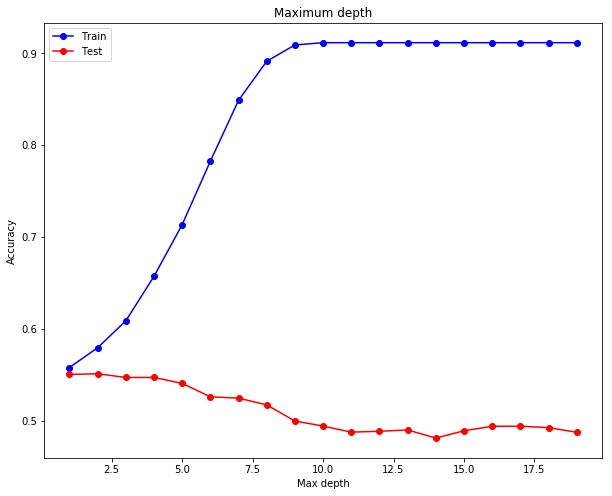

In [113]:
#Gradient boosting exmple
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = GradientBoostingClassifier(max_depth = i, n_estimators = 100)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
    
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

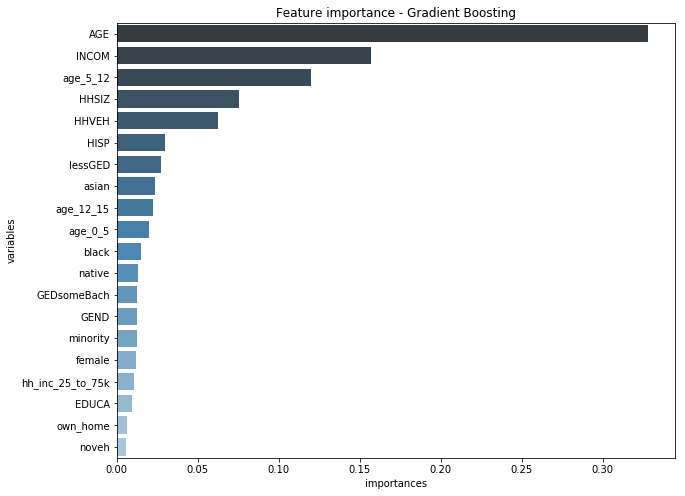

In [114]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100)
model.fit(X_train, y_train)

# importances = model.feature_importances_
# pd.crosstab( y_test, model.predict(X_test))
# model.score(X_test, y_test)

feat_importance = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=feat_importance[:20],palette="Blues_d" )
plt.title('Feature importance - Gradient Boosting');

In [116]:
pd.crosstab( y_test, model.predict(X_test))

col_0,1,2,3,4
School_arrival_TOD,,,,
1,381,452,6,2
2,308,859,20,5
3,48,145,23,3
4,22,45,7,7
5,1,4,0,2


In [117]:
model.score(X_test, y_test)

0.5427350427350427

In [44]:
# Some notes on LL for diferent model specifications
# ASC and age variables, LL = -7,940.215
# + Minority varaibles, LL = -7,925.4763. Comments: Wierd negative signs for CAT 2 and 4. 
# + black variable, LL -7,922.1708. -m "Significat only for CAT 4, meaning more likely to arrive late"
# + native variable, LL = -7,916.5735 -m "Only CAT 3 significant"
# + asian variable, LL = -7,893.469 -m " CAT 2 and 3 are significant. LL decreases significantly"
# + income variables, LL = -7,862.4286 -m "LL improves slightly, CAT 4 and 5 are not significat"
# + Famele variable, LL = -7,857.7048 -m "LL improvemnt insiginifcant. CAT 2, 3, 4 seem significant"
# + Own a home variable , LL = -7,854.6723, -m " LL improvemnt insiginifcant. CAT 2 is insignificant"
# + no vehicle variable, LL = -7,852.684, -m "no significant improvement. No category is important"
# + hh_size_over_4, LL = -7,850.9656, -m "no significnat improvement in LL. No category is significant"

# In total, LL was greater by only 90. Not really impresive considering the number of varibles the model has.


In [594]:
#Trying UrbanSim templantes
orca.add_table('trips', trips_final)
m = SmallMultinomialLogitStep()
m.name = 'STOD_choice'
m.tables = ['trips']
m.choice_column = 'School_arrival_TOD'
m.model_expression = TOD_specification
m.fit()

Log-likelihood at zero: -6,778.9794
Initial Log-likelihood: -6,778.9794
Estimation Time for Point Estimation: 0.62 seconds.
Final log-likelihood: -3,958.7901
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:                7,799
Model:             Multinomial Logit Model   Df Residuals:                    7,770
Method:                                MLE   Df Model:                           29
Date:                     Thu, 22 Aug 2019   Pseudo R-squ.:                   0.416
Time:                             19:05:24   Pseudo R-bar-squ.:               0.412
AIC:                             7,975.580   Log-Likelihood:             -3,958.790
BIC:                             8,177.471   LL-Null:                    -6,778.979
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

In [597]:
#Creating a pkl file
file_Name = "/home/juan/activitysynth/activitysynth/configs/TOD_school_arrival.pkl"
fileObject = open(file_Name,'wb') 
dill.dump(S_TOD_Categories,fileObject)   
fileObject.close()


In [598]:
#Testing pkl file
fileObject = open(file_Name,'rb')  
# load the object from the file into var b
b = pickle.load(fileObject)  
b.get_statsmodels_summary().add_table_params

<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
Dep. Variable:          School_arrival_TOD   No. Observations:                7,799
Model:             Multinomial Logit Model   Df Residuals:                    7,770
Method:                                MLE   Df Model:                           29
Date:                     Thu, 22 Aug 2019   Pseudo R-squ.:                   0.373
Time:                             19:05:49   Pseudo R-bar-squ.:               0.370
AIC:                            15,803.175   Log-Likelihood:             -7,872.587
BIC:                            16,005.066   LL-Null:                   -12,552.006
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
TOD_2                   0.9942      0.144      6.914      0.00

### School departure time

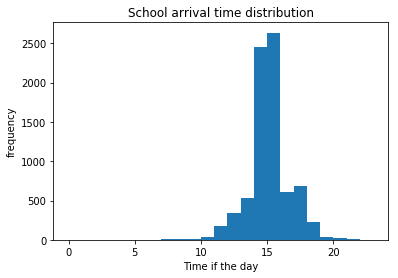

In [599]:
#Plotting distribution for reference 
plt.hist(trips_final.SH_trip_ST, bins= list(range(0,24,1)))
plt.xlabel('Time if the day')
plt.ylabel('frequency')
plt.title('School arrival time distribution');

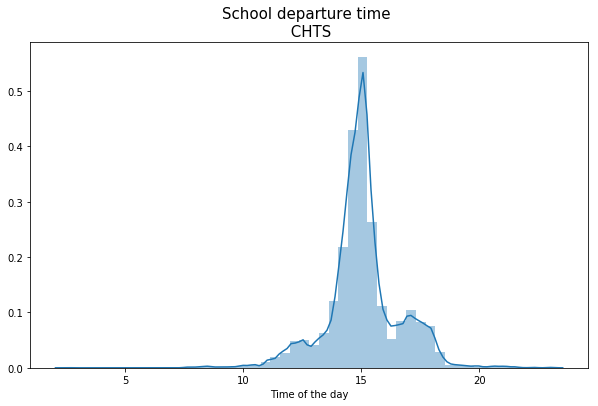

In [124]:
#Plotting distribution for reference 
# plt.hist(trips_final.HS_trip_ET, bins= list(range(0,24,1)))
plt.figure(figsize=(10, 6))
sns.distplot(trips_final.SH_trip_ST)
plt.xlabel('Time of the day')
plt.title('School departure time \n CHTS', fontsize=15);

In [45]:
#Preparing for transformation
ind_variables = ['minority', 'black','native', 'asian', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
                 'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5', 'age_5_12','age_12_15', 
                 'age_15_18',  'female','own_home', 'rent_home', 'noveh', 'hh_size_over_4']

alt_varying_variables = {u'travel_time': dict([(1, 'tt_1'),
                                               (2, 'tt_2'),
                                               (3, 'tt_3'),
                                               (4, 'tt_4'),
                                               (5, 'tt_5')])}

availability_variables = dict(zip(range(1, 6), ['av_1','av_2','av_3','av_4','av_5']))

# Perform the desired conversion
trips_long_departure = pl.convert_wide_to_long(wide_data= trips_final,
                                       ind_vars = ind_variables,
                                       alt_specific_vars = alt_varying_variables,
                                       availability_vars = availability_variables, 
                                       obs_id_col = 'person_id',
                                       choice_col= 'School_departure_TOD')

In [46]:
TOD_SH_ST_specification = OrderedDict()
TOD_SH_ST_names = OrderedDict()

TOD_SH_ST_specification["intercept"] = [2, 3, 4, 5]
TOD_SH_ST_names["intercept"] = ['TOD_2', 'TOD_3', 
                                'TOD_4', 'TOD_5' ]

TOD_SH_ST_specification["age_5_12"] = [2, 3, 4, 5]
TOD_SH_ST_names["age_5_12"] = ['age_5_12_2', 'age_5_12_3', 
                               'age_5_12_4', 'age_5_12_5']

TOD_SH_ST_specification["age_12_15"] = [2, 3, 4, 5]
TOD_SH_ST_names["age_12_15"] = ['age_12_15_2', 'age_12_15_3', 
                                'age_12_15_4', 'age_12_15_5' ]

TOD_SH_ST_specification["age_15_18"] = [2, 3, 4, 5]
TOD_SH_ST_names["age_15_18"] = ['age_15_18_2', 'age_15_18_3',
                                'age_15_18_4', 'age_15_18_5']

TOD_SH_ST_specification['minority'] = [2, 3, 4, 5]
TOD_SH_ST_names['minority'] = ['minority_2', 'minority_3', 
                               'minority_4', 'minority_5']

TOD_SH_ST_specification['asian'] = [2, 3, 4]
TOD_SH_ST_names['asian'] = ['asian_2', 'asian_3', 
                            'asian_4']

TOD_SH_ST_specification['hh_inc_under_25k'] = [2, 3]
TOD_SH_ST_names['hh_inc_under_25k'] = ['hh_inc_under_25k_2', 'hh_inc_under_25k_3']

TOD_SH_ST_specification['hh_inc_25_to_75k'] = [2, 3]
TOD_SH_ST_names['hh_inc_25_to_75k'] = ['hh_inc_25_to_75k_2', 'hh_inc_25_to_75k_3']

TOD_SH_ST_specification['hh_inc_75_to_200k'] = [2, 3]
TOD_SH_ST_names['hh_inc_75_to_200k'] = ['hh_inc_75_to_200k_2', 'hh_inc_75_to_200k_3']

TOD_SH_ST_specification['black'] = [4, 5]
TOD_SH_ST_names['black'] = ['black_4', 'black_5']



In [47]:
len(TOD_SH_ST_names)
len(TOD_SH_ST_specification)

10

In [48]:
S_TOD_Categories = pl.create_choice_model(data=trips_long_departure,
                                     alt_id_col='alt_id',
                                     obs_id_col='person_id',
                                     choice_col='School_departure_TOD',
                                     specification=TOD_SH_ST_specification,
                                     model_type="MNL",
                                     names=TOD_SH_ST_names)

S_TOD_Categories.fit_mle(np.zeros(31))
S_TOD_Categories.get_statsmodels_summary()

Log-likelihood at zero: -12,552.0063
Initial Log-likelihood: -12,552.0063
Estimation Time for Point Estimation: 0.54 seconds.
Final log-likelihood: -8,284.7036


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:        School_departure_TOD   No. Observations:                7,799
Model:             Multinomial Logit Model   Df Residuals:                    7,768
Method:                                MLE   Df Model:                           31
Date:                     Tue, 27 Aug 2019   Pseudo R-squ.:                   0.340
Time:                             15:22:49   Pseudo R-bar-squ.:               0.338
AIC:                            16,631.407   Log-Likelihood:             -8,284.704
BIC:                            16,847.221   LL-Null:                   -12,552.006
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
TOD_2                   0.3044      0.187      1.625      0.104      -0.063       0.671
TOD_3                   0.5036      0.186      2.704      0.007       0.139       0.869
TOD_4                   0.8388      0.164      5.113      0.000       0.517       1.160
TOD_5                  -2.7265      0.599     -4.554      0.000      -3.900      -1.553
age_5_12_2              2.4920      0.180     13.881      0.000       2.140       2.844
age_5_12_3              1.6821      0.178      9.454      0.000       1.333       2.031
age_5_12_4              0.5924      0.183      3.238      0.001       0.234       0.951
age_5_12_5              1.7590      0.639      2.752      0.006       0.506       3.012
age_12_15_2             3.8598      0.350     11.039      0.000       3.174       4.545
age_12_15_3             3.5713      0.348     10.250      0.000       2.888       4.254
age_12_15_4             1.7377      0.359      4.847      0.000       1.035       2.440
age_12_15_5             3.6847      0.717      5.137      0.000       2.279       5.091
age_15_18_2             1.9493      0.191     10.219      0.000       1.575       2.323
age_15_18_3             1.7105      0.188      9.083      0.000       1.341       2.080
age_15_18_4             0.2837      0.198      1.431      0.153      -0.105       0.672
age_15_18_5             2.5631      0.624      4.106      0.000       1.340       3.786
minority_2             -0.5021      0.147     -3.417      0.001      -0.790      -0.214
minority_3             -0.4672      0.149     -3.144      0.002      -0.759      -0.176
minority_4             -0.3971      0.156     -2.541      0.011      -0.703      -0.091
minority_5             -1.2215      0.293     -4.164      0.000      -1.796      -0.647
asian_2                 0.6204      0.232      2.670      0.008       0.165       1.076
asian_3                 0.5948      0.234      2.537      0.011       0.135       1.054
asian_4                 0.8543      0.242      3.526      0.000       0.379       1.329
hh_inc_under_25k_2      0.7266      0.147      4.955      0.000       0.439       1.014
hh_inc_under_25k_3      0.3588      0.154      2.324      0.020       0.056       0.661
hh_inc_25_to_75k_2      0.5392      0.125      4.318      0.000       0.294       0.784
hh_inc_25_to_75k_3      0.4021      0.130      3.090      0.002       0.147       0.657
hh_inc_75_to_200k_2     0.5362      0.116      4.629      0.000       0.309       0.763
hh_inc_75_to_200k_3     0.6155      0.120      5.135      0.000       0.381       0.850
black_4                 0.5258      0.163      3.224      0.001       0.206       0.845
black_5                 0.8312      0.551      1.509      0.131      -0.248       1.911
=======================================================================================
"""

In [626]:
#Creating a pkl file
file_Name = "/home/juan/activitysynth/activitysynth/configs/TOD_school_departure.pkl"
fileObject = open(file_Name,'wb') 
dill.dump(S_TOD_Categories,fileObject)   
fileObject.close()

In [627]:
#Testing pkl file
fileObject = open(file_Name,'rb')  
# load the object from the file into var b
b = pickle.load(fileObject)  
b.get_statsmodels_summary().add_table_params

<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
Dep. Variable:        School_departure_TOD   No. Observations:                7,799
Model:             Multinomial Logit Model   Df Residuals:                    7,768
Method:                                MLE   Df Model:                           31
Date:                     Thu, 22 Aug 2019   Pseudo R-squ.:                   0.340
Time:                             19:44:41   Pseudo R-bar-squ.:               0.338
AIC:                            16,631.407   Log-Likelihood:             -8,284.704
BIC:                            16,847.221   LL-Null:                   -12,552.006
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
TOD_2                   0.3044      0.187      1.625      0.10

# For presentation results

In [41]:
def arrival_from_wide_to_long(data_wide):
    
    #Creating a fake alternative specific varible and its corresponding availability variable. 
    for x in [1,2,3,4,5]:
        name = 'tt_'+str(x)
        av_name = 'av_'+str(x)
        data_wide[name] = [random.randint(1,20) for x in range(len(data_wide))]
        data_wide[av_name] = 1

    #Preparing for transformation
    ind_variables = ['minority', 'black','native', 'asian', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
                     'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5', 'age_5_12','age_12_15', 
                     'age_15_18',  'female','own_home', 'rent_home', 'noveh', 'hh_size_over_4']

    alt_varying_variables = {u'travel_time': dict([(1, 'tt_1'),
                                                   (2, 'tt_2'),
                                                   (3, 'tt_3'),
                                                   (4, 'tt_4'),
                                                   (5, 'tt_5')])}

    availability_variables = dict(zip(range(1, 6), ['av_1','av_2','av_3','av_4','av_5']))
    
    data_wide['obs_id'] = list(range(1, len(data_wide) + 1))

    # Perform the desired conversion
    data_long = pl.convert_wide_to_long(wide_data=data_wide,
                                           ind_vars = ind_variables,
                                           alt_specific_vars = alt_varying_variables,
                                           availability_vars = availability_variables, 
                                           obs_id_col = 'obs_id',
                                           choice_col= 'School_arrival_TOD')
    
    
    return data_long

# Arrival time

In [88]:
TOD_specification = OrderedDict()
TOD_names = OrderedDict()

TOD_specification["intercept"] = [2, 3, 4, 5]
TOD_names["intercept"] = ['TOD_2', 'TOD_3', 'TOD_4', 'TOD_5' ]

TOD_specification["age_5_12"] = [2, 3, 4,]
TOD_names["age_5_12"] = ['age_5_12_2', 'age_5_12_3', 'age_5_12_4' ]

TOD_specification["age_12_15"] = [2, 3, 4, 5]
TOD_names["age_12_15"] = ['age_12_15_2', 'age_12_15_3', 'age_12_15_4', 'age_12_15_5' ]

TOD_specification["age_15_18"] = [2, 3, 4]
TOD_names["age_15_18"] = ['age_15_18_2', 'age_15_18_3', 
                          'age_15_18_4' ]

TOD_specification['minority'] = [2, 3]
TOD_names['minority'] = ['minority_2', 'minority_3']

TOD_specification['asian'] = [2, 3, 4]
TOD_names['asian'] = ['asian_2', 'asian_3', 'asian_4']

TOD_specification['hh_inc_under_25k'] = [2, 3]
TOD_names['hh_inc_under_25k'] = ['hh_inc_under_25k_2', 'hh_inc_under_25k_3']

TOD_specification['hh_inc_25_to_75k'] = [2, 3]
TOD_names['hh_inc_25_to_75k'] = ['hh_inc_25_to_75k_2', 'hh_inc_25_to_75k_3']

TOD_specification['hh_inc_75_to_200k'] = [2, 3]
TOD_names['hh_inc_75_to_200k'] = ['hh_inc_75_to_200k_2', 'hh_inc_75_to_200k_3']

TOD_specification['female'] = [2, 3, 4]
TOD_names['female'] = ['female_2', 'female_3', 'female_4']

TOD_specification['hh_size_over_4'] = [ 4]
TOD_names['hh_size_over_4'] = ['hh_size_over_4_4']


In [89]:
X_train, X_test = train_test_split(trips_final, test_size=0.3, random_state=42)

In [90]:
X_train_long = arrival_from_wide_to_long(X_train)

S_TOD_Categories = pl.create_choice_model(data=X_train_long,
                                     alt_id_col='alt_id',
                                     obs_id_col='obs_id',
                                     choice_col='School_arrival_TOD',
                                     specification=TOD_specification,
                                     model_type="MNL",
                                     names=TOD_names)

S_TOD_Categories.fit_mle(np.zeros(29))
S_TOD_Categories.get_statsmodels_summary().add_table_params

Log-likelihood at zero: -8,785.9216
Initial Log-likelihood: -8,785.9216
Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -5,485.3935


<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
Dep. Variable:          School_arrival_TOD   No. Observations:                5,459
Model:             Multinomial Logit Model   Df Residuals:                    5,430
Method:                                MLE   Df Model:                           29
Date:                     Thu, 26 Sep 2019   Pseudo R-squ.:                   0.376
Time:                             10:03:57   Pseudo R-bar-squ.:               0.372
AIC:                            11,028.787   Log-Likelihood:             -5,485.393
BIC:                            11,220.333   LL-Null:                    -8,785.922
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
TOD_2                   1.0446      0.172      6.057      0.00

In [95]:
#Prediction 
X_test_long = arrival_from_wide_to_long(X_test)
X_test_long['probs'] = S_TOD_Categories.predict(X_test_long)
results = X_test_long.sort_values('probs', ascending = False).groupby('obs_id').agg({'probs': 'first', 'alt_id':'first'}).alt_id
test = pd.Series(X_test.School_arrival_TOD.values, index=X_test.obs_id, name='School_arrival_TOD')

In [96]:
pd.crosstab( test, results)

alt_id,1,2,3
School_arrival_TOD,,,
1,365,476,0
2,303,877,12
3,53,156,10
4,33,47,1
5,5,2,0


In [97]:
score = (test== results).mean()
print ('MNL score is', (score))

MNL score is 0.535042735042735


In [80]:
## GRADEINDT BOOSTING APPROACH

trips_final.columns
variables = ['School_arrival_TOD','GEND', 'AGE', 'HISP',
       'EDUCA', 'HHVEH', 'OWN', 'INCOM',
       'HHSIZ', 'minority', 'black', 'native', 'asian', 'hh_inc_under_25k',
       'hh_inc_25_to_75k', 'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5',
       'age_5_12', 'age_12_15', 'age_15_18', 'lessGED', 'GEDsomeBach',
       'female', 'own_home', 'rent_home', 'noveh', 'hh_size_over_4']

gradient_boosting_data = trips_final[variables]

X = gradient_boosting_data.drop(columns =['School_arrival_TOD'])
y = gradient_boosting_data.School_arrival_TOD
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

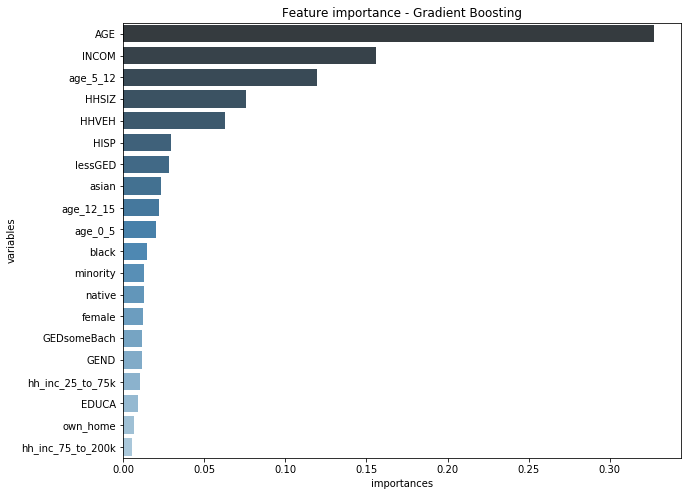

In [81]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100)
model.fit(X_train, y_train)

# importances = model.feature_importances_
# pd.crosstab( y_test, model.predict(X_test))
# model.score(X_test, y_test)

feat_importance = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=feat_importance[:20],palette="Blues_d" )
plt.title('Feature importance - Gradient Boosting');

In [82]:
pd.crosstab(y_test, model.predict(X_test))

col_0,1,2,3,4
School_arrival_TOD,,,,
1,381,452,6,2
2,308,859,20,5
3,48,145,23,3
4,22,45,7,7
5,1,4,0,2


In [83]:
len(y_test)

2340

## Departure

In [102]:
def departure_from_wide_to_long(data_wide):
    
    #Creating a fake alternative specific varible and its corresponding availability variable. 
    for x in [1,2,3,4,5]:
        name = 'tt_'+str(x)
        av_name = 'av_'+str(x)
        data_wide[name] = [random.randint(1,20) for x in range(len(data_wide))]
        data_wide[av_name] = 1

    #Preparing for transformation
    ind_variables = ['minority', 'black','native', 'asian', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
                     'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5', 'age_5_12','age_12_15', 
                     'age_15_18',  'female','own_home', 'rent_home', 'noveh', 'hh_size_over_4']

    alt_varying_variables = {u'travel_time': dict([(1, 'tt_1'),
                                                   (2, 'tt_2'),
                                                   (3, 'tt_3'),
                                                   (4, 'tt_4'),
                                                   (5, 'tt_5')])}

    availability_variables = dict(zip(range(1, 6), ['av_1','av_2','av_3','av_4','av_5']))
    
    data_wide['obs_id'] = list(range(1, len(data_wide) + 1))

    # Perform the desired conversion
    data_long = pl.convert_wide_to_long(wide_data=data_wide,
                                           ind_vars = ind_variables,
                                           alt_specific_vars = alt_varying_variables,
                                           availability_vars = availability_variables, 
                                           obs_id_col = 'obs_id',
                                           choice_col= 'School_departure_TOD')
    
    
    return data_long

In [107]:
TOD_SH_ST_specification = OrderedDict()
TOD_SH_ST_names = OrderedDict()

TOD_SH_ST_specification["intercept"] = [2, 3, 4, 5]
TOD_SH_ST_names["intercept"] = ['TOD_2', 'TOD_3', 
                                'TOD_4', 'TOD_5' ]

TOD_SH_ST_specification["age_5_12"] = [2, 3, 4, 5]
TOD_SH_ST_names["age_5_12"] = ['age_5_12_2', 'age_5_12_3', 
                               'age_5_12_4', 'age_5_12_5']

TOD_SH_ST_specification["age_12_15"] = [2, 3, 4, 5]
TOD_SH_ST_names["age_12_15"] = ['age_12_15_2', 'age_12_15_3', 
                                'age_12_15_4', 'age_12_15_5' ]

TOD_SH_ST_specification["age_15_18"] = [2, 3, 4, 5]
TOD_SH_ST_names["age_15_18"] = ['age_15_18_2', 'age_15_18_3',
                                'age_15_18_4', 'age_15_18_5']

TOD_SH_ST_specification['minority'] = [2, 3, 4, 5]
TOD_SH_ST_names['minority'] = ['minority_2', 'minority_3', 
                               'minority_4', 'minority_5']

TOD_SH_ST_specification['asian'] = [2, 3, 4]
TOD_SH_ST_names['asian'] = ['asian_2', 'asian_3', 
                            'asian_4']

TOD_SH_ST_specification['hh_inc_under_25k'] = [2, 3]
TOD_SH_ST_names['hh_inc_under_25k'] = ['hh_inc_under_25k_2', 'hh_inc_under_25k_3']

TOD_SH_ST_specification['hh_inc_25_to_75k'] = [2, 3]
TOD_SH_ST_names['hh_inc_25_to_75k'] = ['hh_inc_25_to_75k_2', 'hh_inc_25_to_75k_3']

TOD_SH_ST_specification['hh_inc_75_to_200k'] = [2, 3]
TOD_SH_ST_names['hh_inc_75_to_200k'] = ['hh_inc_75_to_200k_2', 'hh_inc_75_to_200k_3']

TOD_SH_ST_specification['black'] = [4, 5]
TOD_SH_ST_names['black'] = ['black_4', 'black_5']

In [104]:
X_train_long

,obs_id,alt_id,School_arrival_TOD,minority,black,native,asian,hh_inc_under_25k,hh_inc_25_to_75k,hh_inc_75_to_200k,hh_inc_over_200k,age_0_5,age_5_12,age_12_15,age_15_18,female,own_home,rent_home,noveh,hh_size_over_4,travel_time,intercept
0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0,1,0,0,1,2,1.0
1,1,2,1,0,0,0,0,1,0,0,0,0,0,1,0,0.0,1,0,0,1,4,1.0
2,1,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0,1,0,0,1,13,1.0
3,1,4,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0,1,0,0,1,20,1.0
4,1,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0,1,0,0,1,17,1.0
5,2,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0.0,1,0,0,1,18,1.0
6,2,2,1,0,0,0,0,0,0,1,0,0,1,0,0,0.0,1,0,0,1,12,1.0
7,2,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0.0,1,0,0,1,4,1.0
8,2,4,0,0,0,0,0,0,0,1,0,0,1,0,0,0.0,1,0,0,1,10,1.0
9,2,5,0,0,0,0,0,0,0,1,0,0,1,0,0,0.0,1,0,0,1,14,1.0


In [108]:
X_train, X_test = train_test_split(trips_final, test_size=0.3, random_state=42)
X_train_long = departure_from_wide_to_long(X_train)

S_TOD_Categories = pl.create_choice_model(data=X_train_long,
                                     alt_id_col='alt_id',
                                     obs_id_col='obs_id',
                                     choice_col='School_departure_TOD',
                                     specification=TOD_SH_ST_specification,
                                     model_type="MNL",
                                     names=TOD_SH_ST_names)

S_TOD_Categories.fit_mle(np.zeros(31))
S_TOD_Categories.get_statsmodels_summary().add_table_params

Log-likelihood at zero: -8,785.9216
Initial Log-likelihood: -8,785.9216
Estimation Time for Point Estimation: 0.57 seconds.
Final log-likelihood: -5,786.4091


<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
Dep. Variable:        School_departure_TOD   No. Observations:                5,459
Model:             Multinomial Logit Model   Df Residuals:                    5,428
Method:                                MLE   Df Model:                           31
Date:                     Thu, 26 Sep 2019   Pseudo R-squ.:                   0.341
Time:                             10:17:07   Pseudo R-bar-squ.:               0.338
AIC:                            11,634.818   Log-Likelihood:             -5,786.409
BIC:                            11,839.574   LL-Null:                    -8,785.922
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
TOD_2                   0.5422      0.222      2.439      0.01

In [109]:
#Prediction 
X_test_long = departure_from_wide_to_long(X_test)
X_test_long['probs'] = S_TOD_Categories.predict(X_test_long)
results = X_test_long.sort_values('probs', ascending = False).groupby('obs_id').agg({'probs': 'first', 'alt_id':'first'}).alt_id
test = pd.Series(X_test.School_departure_TOD.values, index=X_test.obs_id, name='School_departure_TOD')

In [110]:
pd.crosstab( test, results)

alt_id,2,3,4
School_departure_TOD,,,
1,58,13,5
2,996,142,13
3,666,151,20
4,184,45,25
5,17,5,0


In [111]:
score = (test== results).mean()
print ('MNL score is', (score))

MNL score is 0.5008547008547009


In [112]:
## Gradient boosting approach
trips_final.columns
variables = ['School_departure_TOD','GEND', 'AGE', 'HISP',
       'EDUCA', 'HHVEH', 'OWN', 'INCOM',
       'HHSIZ', 'minority', 'black', 'native', 'asian', 'hh_inc_under_25k',
       'hh_inc_25_to_75k', 'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5',
       'age_5_12', 'age_12_15', 'age_15_18', 'lessGED', 'GEDsomeBach',
       'female', 'own_home', 'rent_home', 'noveh', 'hh_size_over_4']

gradient_boosting_data = trips_final[variables]

X = gradient_boosting_data.drop(columns =['School_departure_TOD'])
y = gradient_boosting_data.School_departure_TOD
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

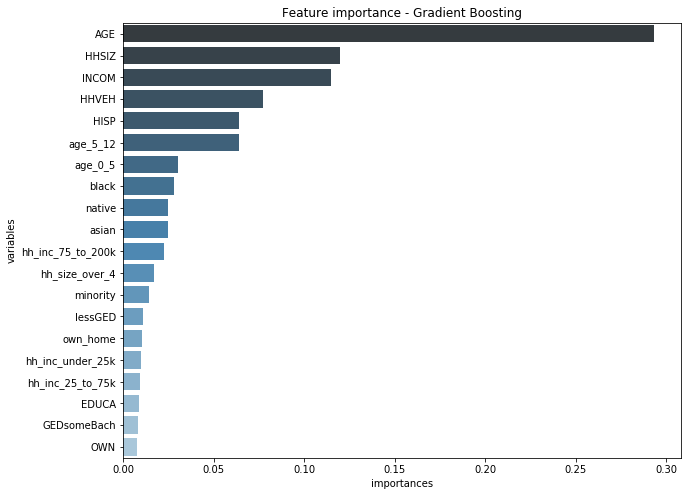

In [113]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100)
model.fit(X_train, y_train)

# importances = model.feature_importances_
# pd.crosstab( y_test, model.predict(X_test))
# model.score(X_test, y_test)

feat_importance = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=feat_importance[:20],palette="Blues_d" )
plt.title('Feature importance - Gradient Boosting');

In [114]:
pd.crosstab(y_test, model.predict(X_test))

col_0,1,2,3,4,5
School_departure_TOD,,,,,
1,0,61,14,1,0
2,8,979,155,7,2
3,7,636,175,19,0
4,3,181,42,28,0
5,0,18,4,0,0


In [116]:
model.score(X_test, y_test)

0.5051282051282051